# Reactional Kinetics Predictor for the Dataset of Stateless Binary Reactions

This notebook loads and processes the unified dataset of reactions from KIDA, UMIST, NFRI and QDB databases, consisting only of binary reactions of stateless species, where no electrons are present (no ionization). Additionaly, only reactions with two products are considered, as this represented the bulk of scraped dataset.
This set has been created elsewhere and already contains the train/test split data.

***
## Frame the problem

This is a problem of training a regression model to estimate a reaction rate coefficient for a plasma reaction.

As a first iteration, I will try to perform a supervised learning on labeled data, and more specifically a *multiple regression* and *univariete regression*.

The original objective was to learn to predict the Arrhenius parameters, which would make it into the *multivariete regression* problem, however, due to the data availability, I am collapsing all the reactional kinetics into a constant reaction rate coefficient, expressed for the room temperature $T_\mathrm{g} = 300~\mathrm{K}$.

The performance is measured with RMSE and MAE error functions on the validation sets (and test set ultimately).

***
## Imports

In [1]:
%matplotlib inline

import itertools
from pathlib import Path
from math import gcd
import random
import joblib

from IPython.display import clear_output
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, RepeatedKFold
from pyvalem.reaction import Reaction

import utils

fw = 12.5  # figure width
fh = 7.0 # figure height

***
## Get the raw data

The dataset has been compiled, filtered and cleaned up elsewhere.

In [2]:
ds_raw = pd.read_csv('dataset_raw.csv', header=0, index_col=0)
ds_raw.info()
print()
print(np.array(ds_raw.columns))
print()
print(ds_raw.value_counts('database'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Columns: 146 entries, reaction_string to exchanged_group_VIIIB
dtypes: float64(46), int64(84), object(16)
memory usage: 10.6+ MB

['reaction_string' 'database' 'database_url' 'source' 'arrhenius_alpha'
 'arrhenius_beta' 'arrhenius_gamma' 'log_k(300K)' 'reactant_1_name'
 'reactant_1_mass' 'reactant_1_charge' 'reactant_1_hform'
 'reactant_1_hform_neutral' 'reactant_1_polarizability'
 'reactant_1_dipole_moment' 'reactant_1_db' 'reactant_1_db_id'
 'reactant_1_block_s' 'reactant_1_block_p' 'reactant_1_block_d'
 'reactant_1_block_f' 'reactant_1_group_IA' 'reactant_1_group_IB'
 'reactant_1_group_IIA' 'reactant_1_group_IIB' 'reactant_1_group_IIIA'
 'reactant_1_group_IIIB' 'reactant_1_group_IVA' 'reactant_1_group_IVB'
 'reactant_1_group_VA' 'reactant_1_group_VB' 'reactant_1_group_VIA'
 'reactant_1_group_VIB' 'reactant_1_group_VIIA' 'reactant_1_group_VIIB'
 'reactant_1_group_VIIIA' 'reactant_1_group_VIIIB' 'reactant_2_name

***
## Features engineering

#### Capping the labels to the *effective minimal* value $k_\min$

The labels were capped to the minimal value of $k_\min = 10^{-20}$ cm$^3$s$^{-1}$

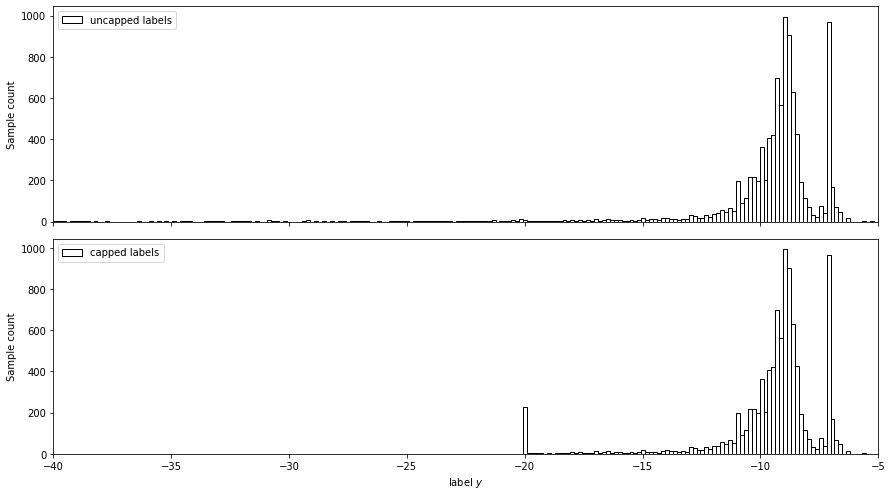

In [3]:
ds = ds_raw.copy()
    
ds.loc[:, 'log_k(300K)_capped'] = utils.cap_y(ds['log_k(300K)'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fw, fh), sharex='all', sharey='all')
bins = np.linspace(-50, 0, 300)
ax1.hist(ds['log_k(300K)'], bins=bins, color='white', edgecolor='black', label='uncapped labels')
ax2.hist(ds['log_k(300K)_capped'], bins=bins, color='white', edgecolor='black', label='capped labels')
for ax in (ax1, ax2):
    ax.set_xlim(-40, -5)
    ax.set_ylabel('Sample count')
    ax.legend()
ax2.set_xlabel('label $y$')

fig.tight_layout()

ds.drop(
    columns=[
        'log_k(300K)', 'database', 'source', 'database_url', 'reaction_string', 
        'arrhenius_alpha', 'arrhenius_beta', 'arrhenius_gamma'
    ] + 
    [
        f'{rp}_{num}_{attr}' 
        for rp in ['reactant', 'product'] 
        for num in [1, 2] 
        for attr in ['db', 'db_id']
    ], 
    inplace=True
)

#### Missing values
Some data instances have missing values of enthalpy of formation, polarizability or dipole moment of some of the 
reactants and products. These values will need to be imputed in the processing pipeline, before the final features 
engineering dataset transformation.

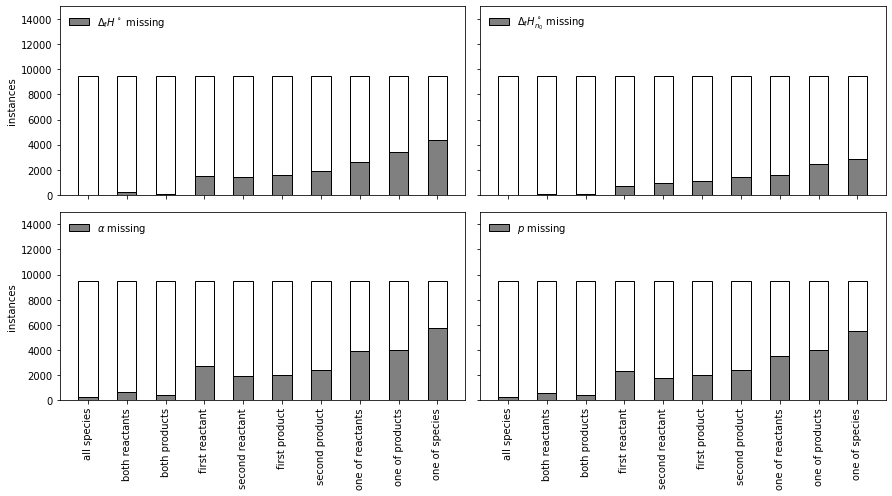

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(fw, fh), sharex='all', sharey='all')

total = len(ds)
categories1 = ['hform', 'hform_neutral', 'polarizability', 'dipole_moment']
categories2 = [r'$\Delta_\mathrm{f} H ^\circ$', r'$\Delta_\mathrm{f} H ^\circ _{n_0}$', r'$\alpha$', r'$p$']

for ax_i, (ax, cat1, cat2) in enumerate(zip(axes.flatten(), categories1, categories2)):
    columns = [f'{rp}_{num}_{cat1}' for rp in ['reactant', 'product'] for num in [1, 2]]
    labels = [f'{num} {rp}' for rp in ['reactant', 'product'] for num in ['first', 'second']]
    missing = [sum(ds[col].isna()) for col in columns]

    labels = ['all species', 'both reactants', 'both products'] + labels + \
             ['one of reactants', 'one of products', 'one of species']

    missing = [
                  sum(
                      ~(~ds[f'reactant_1_{cat1}'].isna() |
                        ~ds[f'reactant_2_{cat1}'].isna() |
                        ~ds[f'product_1_{cat1}'].isna() |
                        ~ds[f'product_2_{cat1}'].isna()
                        )
                  ),
                  sum(~(~ds[f'reactant_1_{cat1}'].isna() | ~ds[f'reactant_2_{cat1}'].isna())),
                  sum(~(~ds[f'product_1_{cat1}'].isna() | ~ds[f'product_2_{cat1}'].isna()))
              ] + missing + [
                  sum(~(~ds[f'reactant_1_{cat1}'].isna() & ~ds[f'reactant_2_{cat1}'].isna())),
                  sum(~(~ds[f'product_1_{cat1}'].isna() & ~ds[f'product_2_{cat1}'].isna())),
                  sum(
                      ~(~ds[f'reactant_1_{cat1}'].isna() &
                        ~ds[f'reactant_2_{cat1}'].isna() &
                        ~ds[f'product_1_{cat1}'].isna() &
                        ~ds[f'product_2_{cat1}'].isna()
                        )
                  )
              ]

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)

    width = 0.5
    ax.bar(range(len(labels)), len(labels) * [total], color='white', edgecolor='black', width=width)
    ax.bar(range(len(labels)), missing, color='gray', edgecolor='black', width=width, label=f'{cat2} missing')
    ax.set_ylim(0, 15_000)
    ax.legend(loc='upper left', frameon=False)
    if ax_i in {0, 2}:
        ax.set_ylabel('instances')

fig.tight_layout();

#### Species mass
Replace the masses with reduced masses

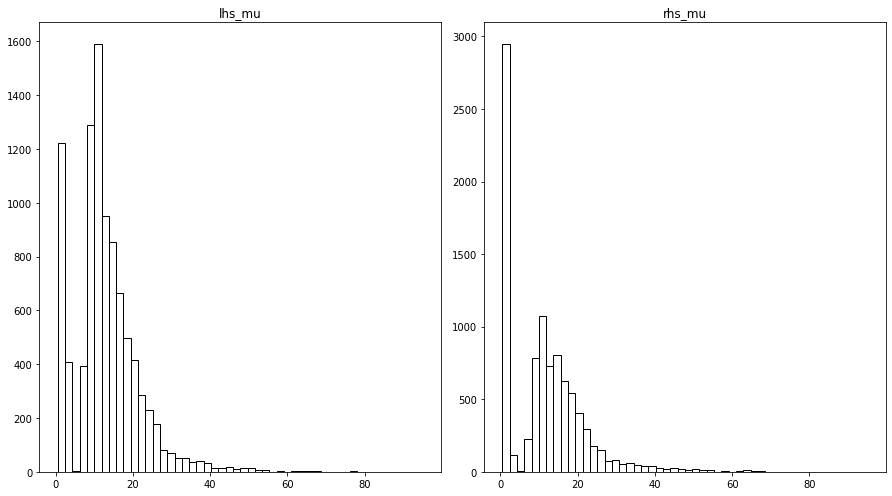

In [5]:
ds_mass = ds.copy().drop(columns=['log_k(300K)_capped'])

ds_mass['lhs_mu'] = (ds['reactant_1_mass'] * ds['reactant_2_mass']) / (ds['reactant_1_mass'] + ds['reactant_2_mass'])
ds_mass['rhs_mu'] = (ds['product_1_mass'] * ds['product_2_mass']) / (ds['product_1_mass'] + ds['product_2_mass'])
# Cannot drop the individual masses yet, as I will need them for polarizability and dipole moment features!

ds_mass.hist(['lhs_mu', 'rhs_mu'], grid=False, bins=50, color='white', edgecolor='black', figsize=(fw, fh))
plt.gcf().tight_layout();

#### Species charge
Create one-hot encoding of all the charge combinations on left-hand and right-hand sides

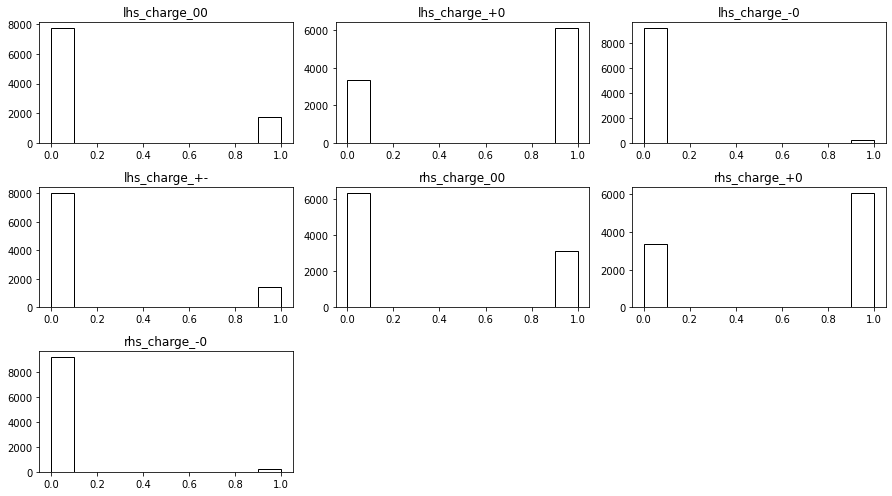

In [6]:
ds_charge = ds_mass.copy()

charge_labels = ['00', '++', '--', '+0', '-0', '+-']
charge_combos = [(0, 0), (1, 1), (-1, -1), (1, 0), (-1, 0), (1, -1)]

for side, rp in zip(['lhs', 'rhs'], ['reactant', 'product']):
    for ch_label, (ch1, ch2) in zip(charge_labels, charge_combos):
        one_hot_charge = (
            ((ds[f'{rp}_1_charge'] == ch1) & (ds[f'{rp}_2_charge'] == ch2)) | 
            ((ds[f'{rp}_2_charge'] == ch1) & (ds[f'{rp}_1_charge'] == ch2))
        ).astype(float)
        if (one_hot_charge == 1).any():
            ds_charge[f'{side}_charge_{ch_label}'] = one_hot_charge
# Cannot drop the individual charges yet, as I will need them for polarizability and dipole moment features!

# skewed data detection:
ds_charge.hist(
    ['lhs_charge_00', 'lhs_charge_+0', 'lhs_charge_-0', 'lhs_charge_+-', 
     'rhs_charge_00', 'rhs_charge_+0', 'rhs_charge_-0'], 
    grid=False, color='white', edgecolor='black', figsize=(fw, fh)
)
plt.gcf().tight_layout();
ds_charge.drop(columns=['lhs_charge_-0', 'rhs_charge_-0'], inplace=True)

#### Blocks
Merge some block categories together. Looks like there are no elements present from `f` group and only a few from `d` group, so these two will be eliminiated.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reactant_1_block_s  5515 non-null   float64
 1   reactant_1_block_p  8463 non-null   float64
 2   reactant_1_block_d  48 non-null     float64
 3   reactant_1_block_f  0 non-null      float64
 4   reactant_2_block_s  5942 non-null   float64
 5   reactant_2_block_p  8629 non-null   float64
 6   reactant_2_block_d  36 non-null     float64
 7   reactant_2_block_f  0 non-null      float64
dtypes: float64(8)
memory usage: 665.9 KB


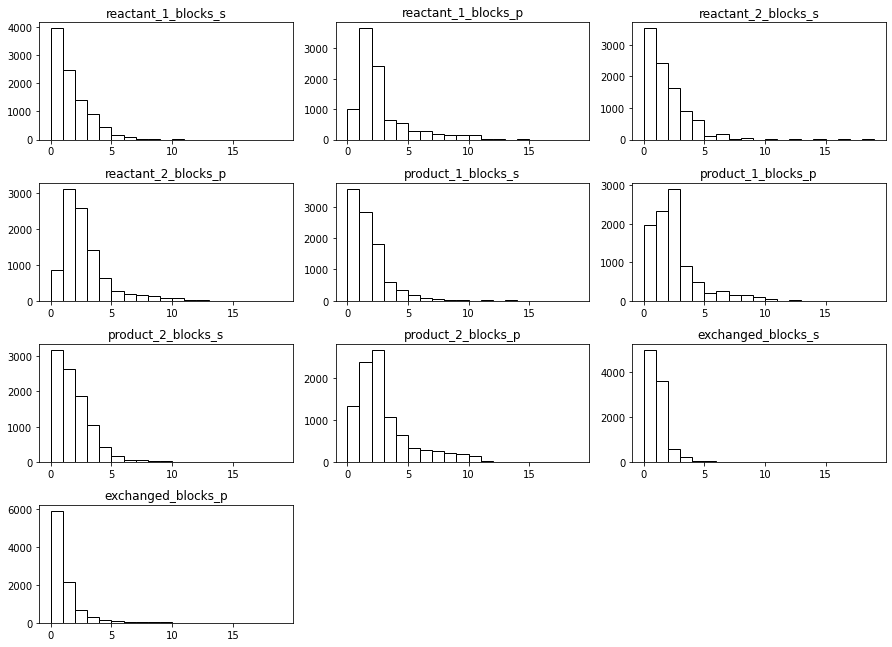

In [7]:
ds_blocks = ds_charge.copy()

block_cols_show = [f'{which}_block_{block}' 
                   for which in ('reactant_1', 'reactant_2') 
                   for block in ('s', 'p', 'd', 'f')]
ds_blocks[block_cols_show].replace(0, np.nan).info()

prefixes = [f'{rp}_{num}' for rp in ['reactant', 'product'] for num in [1, 2]] + ['exchanged']
block_cols = [f'{prefix}_block_{block}' for prefix in prefixes for block in ('s', 'p', 'd', 'f')]
for prefix in prefixes:
    ds_blocks[f'{prefix}_blocks_s'] = ds[f'{prefix}_block_s']
    ds_blocks[f'{prefix}_blocks_p'] = ds[f'{prefix}_block_p']
ds_blocks.drop(columns=block_cols, inplace=True)

# skewed data detection:
ds_blocks.hist(
    [f'{prefix}_blocks_{block}' for prefix in prefixes for block in ['s', 'p']], 
    grid=False, color='white', edgecolor='black', figsize=(fw, fh*1.3), bins=range(20)
)
plt.gcf().tight_layout();

#### Groups
Merge some group categories together

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reactant_1_group_IA     5473 non-null   float64
 1   reactant_1_group_IB     2 non-null      float64
 2   reactant_1_group_IIA    14 non-null     float64
 3   reactant_1_group_IIB    0 non-null      float64
 4   reactant_1_group_IIIA   2 non-null      float64
 5   reactant_1_group_IIIB   2 non-null      float64
 6   reactant_1_group_IVA    5812 non-null   float64
 7   reactant_1_group_IVB    9 non-null      float64
 8   reactant_1_group_VA     1413 non-null   float64
 9   reactant_1_group_VB     4 non-null      float64
 10  reactant_1_group_VIA    2232 non-null   float64
 11  reactant_1_group_VIB    1 non-null      float64
 12  reactant_1_group_VIIA   696 non-null    float64
 13  reactant_1_group_VIIB   0 non-null      float64
 14  reactant_1_group_VIIIA  145 non-null    

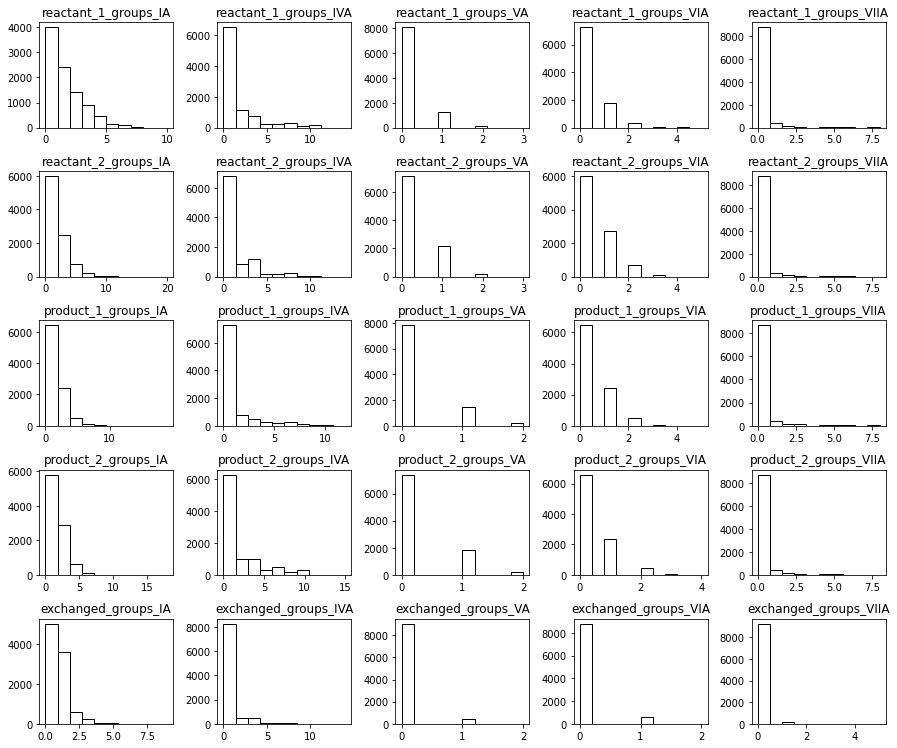

In [8]:
ds_groups = ds_blocks.copy()

prefixes = prefixes = [f'{rp}_{num}' for rp in ['reactant', 'product'] for num in [1, 2]] + ['exchanged']
groups = [f'{gr1}{gr2}' for gr1 in 'I II III IV V VI VII VIII'.split() for gr2 in 'A B'.split()]
group_cols = [f'{prefix}_group_{gr}' for prefix in prefixes for gr in groups]
group_cols_show = [gc for gc in group_cols if 'reactant' in gc]
ds_groups[group_cols_show].replace(0, np.nan).info()

groups_to_keep = 'IA IVA VA VIA VIIA'.split()
for which in prefixes:
    for group in groups_to_keep:
        ds_groups[f'{which}_groups_{group}'] = ds[f'{which}_group_{group}']

ds_groups.drop(columns=group_cols, inplace=True)

# skewed data detection:
ds_groups.hist(
    [f'{prefix}_groups_{gr}' for prefix in prefixes for gr in groups_to_keep], 
    grid=False, color='white', edgecolor='black', figsize=(fw, fh*1.5)
)
plt.gcf().tight_layout();

#### Species attributes

Features regarding the hform, hform_neutral, polarizability and dipole_moment will have to be created only after the missing values imputation, in the data transformation pipeline, acting only on the training part of the dataset (leaving the test values out of the imputer training)
* `lhs_hform` = `reactant_1_hform` + `reactant_2_hform`
* `rhs_hform` = `product_1_hform` + `product_2_hform`
* `delta_hform` = `rhs_hform` - `lhs_hform`
* `lhs_hform_neutral` = `reactant_1_hform_neutral` + `reactant_2_hform_neutral`
* `rhs_hform_neutral` = `product_1_hform_neutral` + `product_2_hform_neutral`
* `delta_hform_neutral` = `rhs_hform_neutral` - `lhs_hform_neutral`
* `lhs_polarizability_factor` = 
max(`reactant_1_polarizability` $\times$ `reactant_2_charge` $^2$, `reactant_2_polarizability` $\times$ `reactant_1_charge` $^2$)
* `rhs_polarizability_factor` = 
max(`product_1_polarizability` $\times$ `product_2_charge` $^2$, `product_2_polarizability` $\times$ `product_1_charge` $^2$)
* `lhs_dipole_moment_factor` = 
max(`reactant_1_dipole_moment` $\times$ `reactant_2_charge`, `reactant_2_dipole_moment` $\times$ `reactant_1_charge`)
* `rhs_dipole_moment_factor` = 
max(`product_1_dipole_moment` $\times$ `product_2_charge`, `product_2_dipole_moment` $\times$ `product_1_charge`)

In [9]:
test = True
if test:
    transformer = utils.SpeciesAttributesTransformer()
    
    ds_test = ds_groups.copy()
    ds_test_transformed = transformer.fit_transform(ds_test)
    
    ds_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   reactant_1_mass            9470 non-null   float64
 1   reactant_2_mass            9470 non-null   float64
 2   product_1_mass             9470 non-null   float64
 3   product_2_mass             9470 non-null   float64
 4   exchanged_mass             9470 non-null   float64
 5   exchanged_atoms            9470 non-null   float64
 6   lhs_mu                     9470 non-null   float64
 7   rhs_mu                     9470 non-null   float64
 8   lhs_charge_00              9470 non-null   float64
 9   lhs_charge_+0              9470 non-null   float64
 10  lhs_charge_+-              9470 non-null   float64
 11  rhs_charge_00              9470 non-null   float64
 12  rhs_charge_+0              9470 non-null   float64
 13  exchanged_blocks_s         9470 non-null   float

#### Imputation
Custom class imputing the species attributes. Based on `IterativeImputer` with `BayesianRidge`, but keeping conception of species identity.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   reactant_1_name            9470 non-null   object 
 1   reactant_1_charge          9470 non-null   int64  
 2   reactant_1_hform           9470 non-null   float64
 3   reactant_1_hform_neutral   9470 non-null   float64
 4   reactant_1_polarizability  9470 non-null   float64
 5   reactant_1_dipole_moment   9470 non-null   float64
 6   reactant_2_name            9470 non-null   object 
 7   reactant_2_charge          9470 non-null   int64  
 8   reactant_2_hform           9470 non-null   float64
 9   reactant_2_hform_neutral   9470 non-null   float64
 10  reactant_2_polarizability  9470 non-null   float64
 11  reactant_2_dipole_moment   9470 non-null   float64
 12  product_1_name             9470 non-null   object 
 13  product_1_charge           9470 non-null   int64

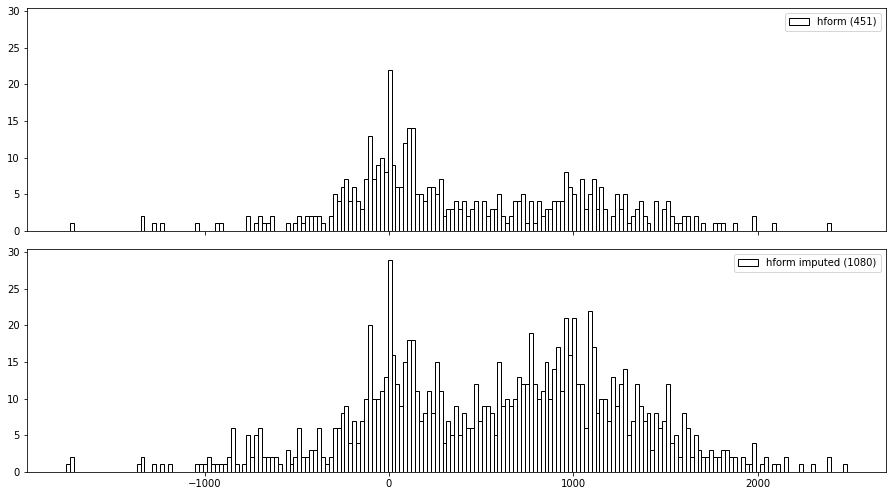

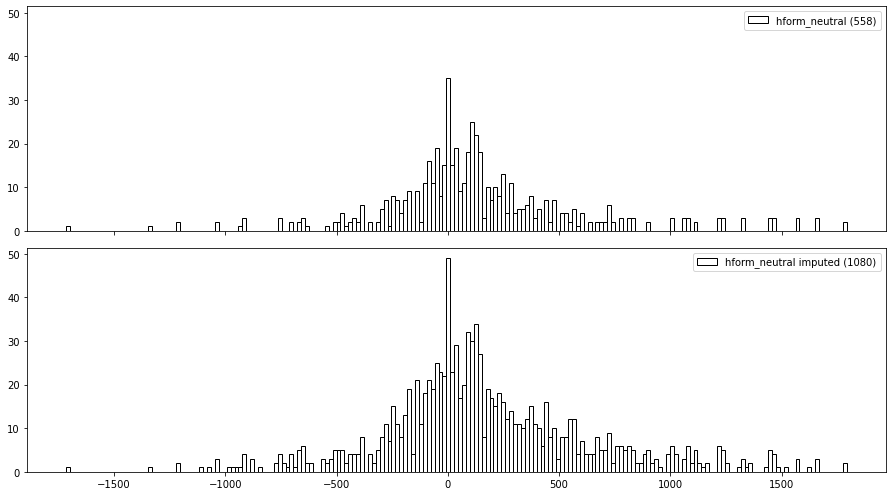

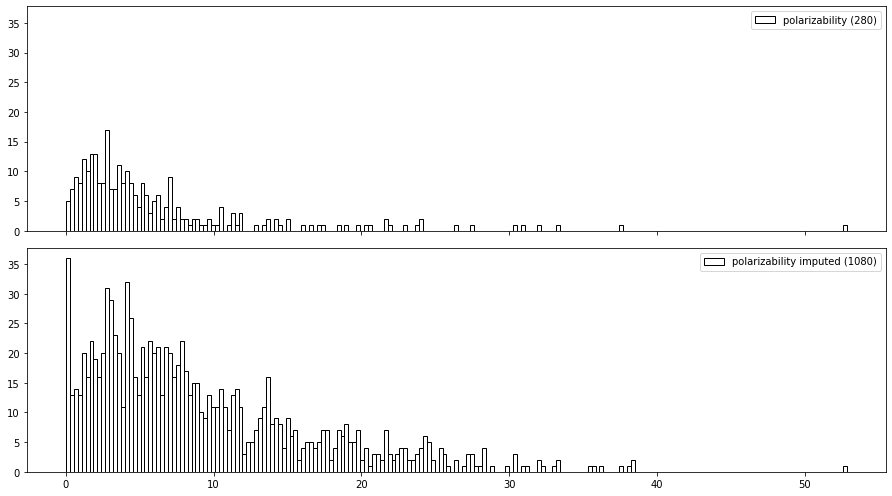

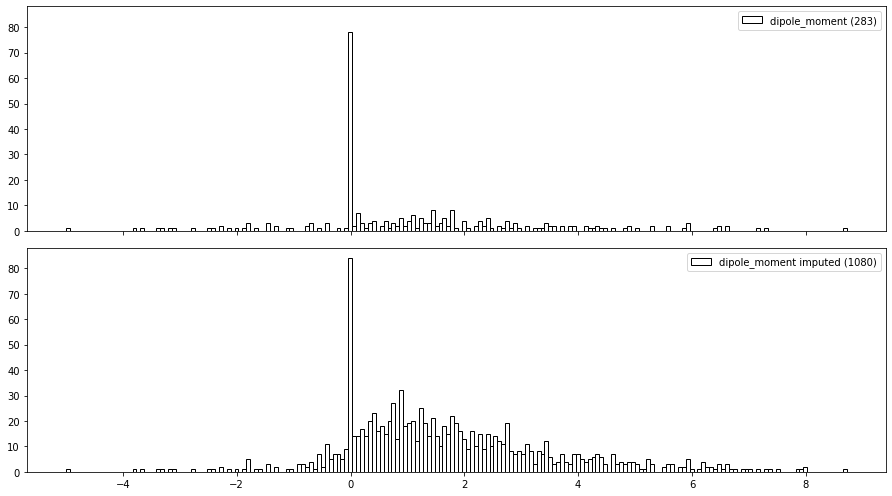

In [10]:
test = True
if test:
    imputer = utils.SpeciesAttributesImputer()
        
    ds_test = ds_groups.copy()
    ds_test_imputed = imputer.fit_transform(ds_test)
    
    ds_test_imputed.info()
    
    sp_df = utils.SpeciesAttributesImputer.distinct_species_df(ds_test)
    sp_df_imputed = utils.SpeciesAttributesImputer.distinct_species_df(ds_test_imputed)
    
    for sp_attr in ['hform', 'hform_neutral', 'polarizability', 'dipole_moment']:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fw, fh), sharex='all', sharey='all')
        min_val = min(min(sp_df[sp_attr]), min(sp_df_imputed[sp_attr]))
        max_val = max(max(sp_df[sp_attr]), max(sp_df_imputed[sp_attr]))
        bins = np.linspace(min_val, max_val, 200)
        ax1.hist(sp_df[sp_attr], bins=bins, color='white', edgecolor='black', label=f'{sp_attr} ({len(sp_df[sp_attr][~sp_df[sp_attr].isna()])})')
        ax2.hist(sp_df_imputed[sp_attr], bins=bins, color='white', edgecolor='black', label=f'{sp_attr} imputed ({len(sp_df_imputed[sp_attr])})')
        ax1.legend()
        ax2.legend()
        fig.tight_layout();

***
## Data transformation pipeline

In [11]:
transform_pipeline = Pipeline([
    ('imputer', utils.SpeciesAttributesImputer()), 
    ('transformer', utils.SpeciesAttributesTransformer()), 
])

transform_scale_pipeline = Pipeline([
    ('imputer', utils.SpeciesAttributesImputer()), 
    ('transformer', utils.SpeciesAttributesTransformer()), 
    ('scaler', utils.Scaler()),
])

test = True
if test:
    ds_test = ds_groups.copy()
    ds_test_transformed_scaled = transform_scale_pipeline.fit_transform(ds_test)
    ds_test_transformed_scaled.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   exchanged_mass             9470 non-null   float64
 1   exchanged_atoms            9470 non-null   float64
 2   lhs_mu                     9470 non-null   float64
 3   rhs_mu                     9470 non-null   float64
 4   lhs_charge_00              9470 non-null   float64
 5   lhs_charge_+0              9470 non-null   float64
 6   lhs_charge_+-              9470 non-null   float64
 7   rhs_charge_00              9470 non-null   float64
 8   rhs_charge_+0              9470 non-null   float64
 9   exchanged_blocks_s         9470 non-null   float64
 10  exchanged_blocks_p         9470 non-null   float64
 11  exchanged_groups_IA        9470 non-null   float64
 12  exchanged_groups_IVA       9470 non-null   float64
 13  exchanged_groups_VA        9470 non-null   float

***
## Data analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9470 entries, 0 to 9469
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   exchanged_mass             9470 non-null   float64
 1   exchanged_atoms            9470 non-null   float64
 2   lhs_mu                     9470 non-null   float64
 3   rhs_mu                     9470 non-null   float64
 4   lhs_charge_00              9470 non-null   float64
 5   lhs_charge_+0              9470 non-null   float64
 6   lhs_charge_+-              9470 non-null   float64
 7   rhs_charge_00              9470 non-null   float64
 8   rhs_charge_+0              9470 non-null   float64
 9   exchanged_blocks_s         9470 non-null   float64
 10  exchanged_blocks_p         9470 non-null   float64
 11  exchanged_groups_IA        9470 non-null   float64
 12  exchanged_groups_IVA       9470 non-null   float64
 13  exchanged_groups_VA        9470 non-null   float

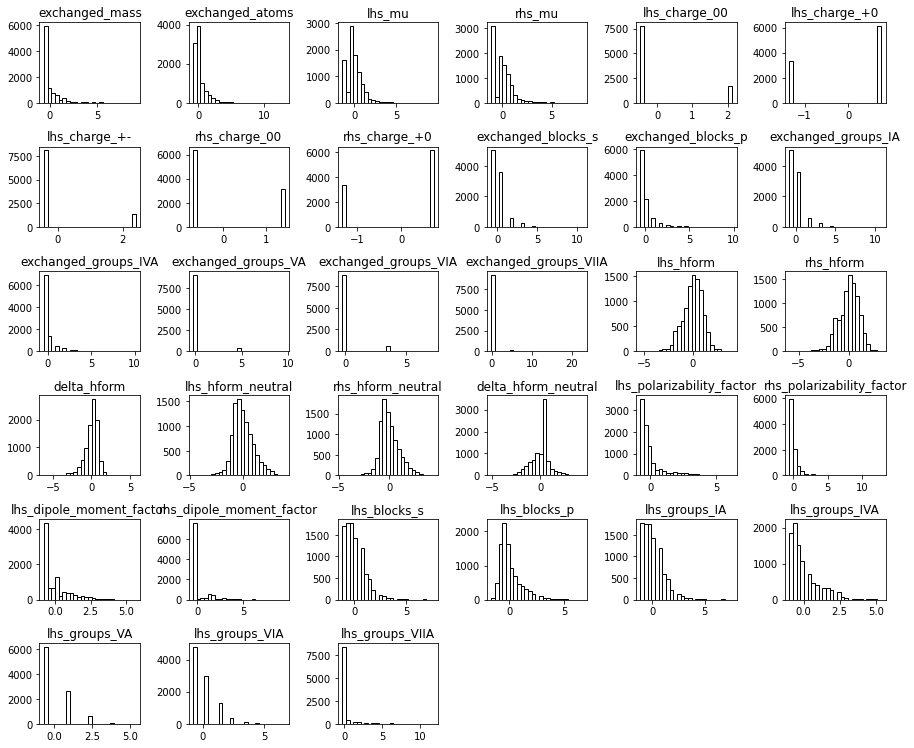

In [12]:
transform_pipeline.fit_transform(ds_groups.copy()).to_csv('/home/martin/Documents/phd-thesis/figures_src/dataset_eda/features.csv')
transform_scale_pipeline.fit_transform(ds_groups.copy()).to_csv('/home/martin/Documents/phd-thesis/figures_src/dataset_eda/features_scaled.csv')

X_transformed = transform_scale_pipeline.fit_transform(ds_groups.copy())
X_transformed.info()
X_transformed.hist( 
    grid=False, color='white', edgecolor='black', figsize=(fw, fh*1.5), bins=25
)
plt.gcf().tight_layout();

***
## Train-Test set split


In [13]:
X = ds_groups.copy()
random.seed(42)
X.loc[random.sample(list(X.index), 10)].to_csv('sample_input.csv')

y = ds.copy()['log_k(300K)_capped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_prep = transform_scale_pipeline.fit_transform(X_train.copy())
X_test_prep = transform_scale_pipeline.transform(X_test.copy())
X_all_prep = transform_scale_pipeline.transform(X.copy())

y_all = y.copy()

print(f'Train/test sizes: {len(X_train)}/{len(X_test)}')

X_train_prep

Train/test sizes: 7576/1894


,exchanged_mass,exchanged_atoms,lhs_mu,rhs_mu,lhs_charge_00,lhs_charge_+0,lhs_charge_+-,rhs_charge_00,rhs_charge_+0,exchanged_blocks_s,...,rhs_polarizability_factor,lhs_dipole_moment_factor,rhs_dipole_moment_factor,lhs_blocks_s,lhs_blocks_p,lhs_groups_IA,lhs_groups_IVA,lhs_groups_VA,lhs_groups_VIA,lhs_groups_VIIA
6025,1.149621,-0.198572,0.414247,-0.964792,-0.474235,0.742420,-0.415639,-0.703260,0.742420,-0.784257,...,-0.271011,-0.262123,-0.438591,0.168271,-0.895879,0.174208,-0.978558,0.858497,0.271005,-0.26983
7562,-0.578221,-0.812103,1.399628,1.304140,-0.474235,-1.346946,2.405937,1.421949,-1.346946,-0.784257,...,-0.587070,0.929460,-0.438591,0.609689,1.268286,0.613994,1.667486,-0.658288,-0.795559,-0.26983
3990,0.879396,2.255555,0.002973,-1.059815,2.108659,-1.346946,-0.415639,1.421949,-1.346946,3.130656,...,-0.587070,-0.782440,-0.438591,0.609689,-0.174491,0.613994,0.344464,-0.658288,-0.795559,-0.26983
4401,-0.578221,-0.812103,-0.082105,0.043564,-0.474235,-1.346946,2.405937,1.421949,-1.346946,-0.784257,...,-0.587070,-0.453621,-0.438591,-0.714567,-0.895879,-0.705365,-0.647802,0.858497,-0.795559,-0.26983
472,-0.578221,-0.812103,-1.377982,-1.058894,-0.474235,0.742420,-0.415639,-0.703260,0.742420,-0.784257,...,-0.319324,1.847573,-0.438591,-0.273148,1.268286,-0.265579,1.336730,0.858497,-0.795559,-0.26983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-0.578221,-0.812103,0.487993,0.528572,-0.474235,-1.346946,2.405937,1.421949,-1.346946,-0.784257,...,-0.587070,0.292529,-0.438591,-1.155986,-0.535185,-1.145151,-0.978558,0.858497,0.271005,-0.26983
5191,1.418067,1.642023,0.394465,-0.964697,-0.474235,0.742420,-0.415639,-0.703260,0.742420,0.520714,...,-0.271011,-0.782440,-0.438591,1.933946,0.186203,1.933354,0.675220,-0.658288,-0.795559,-0.26983
5390,-0.578221,-0.812103,0.530037,0.564341,-0.474235,0.742420,-0.415639,-0.703260,0.742420,-0.784257,...,1.004066,0.168613,3.024739,-0.714567,-0.174491,-0.705365,-0.317047,-0.658288,1.337569,-0.26983
860,-0.523896,-0.198572,-1.161927,-0.965630,-0.474235,0.742420,-0.415639,-0.703260,0.742420,0.520714,...,-0.271011,0.957134,-0.438591,0.168271,-0.535185,0.174208,-0.317047,0.858497,-0.795559,-0.26983


***
## Machine learning
The individual models were selected elsewhere and their hyperparameters were tuned elsewhere.

#### Metrics

In [14]:
# custom scorers, which cap the predicted values before MAE or RMSE are evaluated. the real y are already capped 
# from the data pre-processing

def mae_cap(y, y_pred):
    if hasattr(y, 'index') and hasattr(y_pred, 'index'):
        assert list(y.index) == list(y_pred.index)
    return np.mean(np.absolute(y - utils.cap_y(y_pred)))

def rmse_cap(y, y_pred):
    if hasattr(y, 'index') and hasattr(y_pred, 'index'):
        assert list(y.index) == list(y_pred.index)
    return np.mean((y - utils.cap_y(y_pred)) ** 2) ** 0.5

def run_crossvalidation(model, X, y, scoring_functions=(('mae_cap', mae_cap), ('rmse_cap', rmse_cap)),
                        random_seed=42, val_size=0.2, num_splits=5, verbose=False):
    """Runs a cross-validation using the RepeatedKFold strategy.
    val_size will be re-adjusted to the closest 1/num_folds and 
    num_splits will be readjuted to closest k*num_folds
    The scoring_functions is a tuple of name, function pairs, 
    where the function take y_pred and y_train and return real score.
    
    Returns a dataframe with columns the same as scoring function names and with each row 
    belonging to a single CV-fold.
    """
    num_folds = round(1/val_size)
    num_reps = round(num_splits/num_folds)
    fold_scores = pd.DataFrame()
    rkfold = RepeatedKFold(n_splits=num_folds, n_repeats=num_reps, random_state=random_seed)
    for i, (train_index, val_index) in enumerate(rkfold.split(X)):
        X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
        y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train_split, y_train_split)
        y_train_split_pred = model.predict(X_train_split)
        y_val_split_pred = model.predict(X_val_split)
        for name, scoring_f in scoring_functions:
            train_score = scoring_f(y_train_split, y_train_split_pred)
            val_score = scoring_f(y_val_split, y_val_split_pred)
            fold_scores.at[i, f'{name}_train'] = train_score
            fold_scores.at[i, f'{name}_val'] = val_score
            if verbose:
                print(f'Fold {i + 1} ({name}): \t Training score: {train_score}, \t Validation score: {val_score}')
    return fold_scores

crossval_scores_table = pd.DataFrame()
col_map = {
    'mae_cap_train': 'MAE_train',
    'mae_cap_val': 'MAE', 
    'rmse_cap_train': 'RMSE_train',
    'rmse_cap_val': 'RMSE', 
}

def crossval_scores(model, X, y, scoring_functions=(('mae_cap', mae_cap), ('rmse_cap', rmse_cap)),
                    random_seed=42, val_size=0.2, num_splits=5, verbose=False, show_table=True):
    fold_scores = run_crossvalidation(model, X, y, scoring_functions, 
                                      random_seed, val_size, num_splits, verbose)
    model_name = str(type(model)).split(".")[-1].split("'")[0]
    for col in fold_scores.columns:
        crossval_scores_table.at[model_name, col_map[col]] = np.mean(fold_scores[col])
        crossval_scores_table.at[model_name, f's({col_map[col]})'] = np.std(fold_scores[col])
    
    if show_table:
        with pd.option_context('display.max_colwidth', None):
            display(crossval_scores_table)


#### Randomized hyperparameter search (custom)

In [15]:
def run_randomized_search(
    model_cls, X, y, param_distributions, save_memo_to, random_state=42, timeout=300, 
    plot_train_vs_val=True, print_scores=True, integration_strategy='mean', plot_only=False
):
        
    sc_name, sc_f = 'mae_cap', mae_cap
    crossval_results = [f'{sc_name}_train', f'{sc_name}_train_std', f'{sc_name}_val', f'{sc_name}_val_std']
    fig, ax = None, None
    memo_dir = Path(os.path.abspath('')).joinpath('_cache')
    if not memo_dir.is_dir():
        memo_dir.mkdir()
    save_memo_to = memo_dir.joinpath(save_memo_to)
    
    def show_output(print_header=True):
        if plot_train_vs_val or print_scores:
            clear_output(wait=True)
        if plot_train_vs_val:
            fig, ax = plt.subplots(figsize=(fw, 4.6))
            x = np.arange(len(memo))
            if model_cls is VotingRegressor:
                x_labels = [', '.join([str(val) for val in memo.loc[i, keys[1]]]) for i in memo.index]
            else:
                x_labels = [', '.join([str(val) for val in memo.loc[i, keys]]) for i in memo.index]
            ax.errorbar(
                x, memo[f'{sc_name}_train'], yerr=memo[f'{sc_name}_train_std'], fmt='-o', 
                label=f'{sc_name} (x-val training folds)'
            )
            ax.errorbar(
                x, memo[f'{sc_name}_val'], yerr=memo[f'{sc_name}_val_std'], fmt='-o',
                label=f'{sc_name} (x-val validation folds)'
            )
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)
            ax.tick_params(axis='x', rotation=90)
            ax.grid()
            fig.tight_layout()
            plt.show();
        if print_scores:
            if print_header:
                print(f'{datetime.now().strftime("%H:%M:%S")} ({it_no + 1}): {repr(model)}\n')
            print(memo[keys + ['time', f'{sc_name}_val']].to_string(index=False))
    
    if save_memo_to.is_file():
        memo = pd.read_csv(save_memo_to, index_col=0)
    else:
        memo = pd.DataFrame(columns=list(param_distributions.keys()) + ['time', ] + crossval_results)
    keys = list(memo.columns)[:-len(['time'] + crossval_results)]
    assert set(keys) == set(param_distributions.keys())
    assert list(memo.columns)[-len(['time'] + crossval_results):] == ['time'] + crossval_results
    indices = tuple(tuple(range(len(param_distributions[key]))) for key in keys)
    all_combinations = list(itertools.product(*indices))
    random.Random(random_state).shuffle(all_combinations)
    
    if not plot_only:
        combination_depleted = True
        for it_no, index in enumerate(all_combinations):
            if str(index) not in memo.index:
                combination_depleted = False
                params = {key: param_distributions[key][i] for key, i in zip(keys, index)}
                model = model_cls(**params)

                show_output()

                def process_target(return_dict):
                    fold_scores = run_crossvalidation(model, X, y, ((sc_name, sc_f), ), val_size=0.2, num_splits=5)
                    if integration_strategy == 'mean':
                        return_dict[f'{sc_name}_train'] = np.mean(fold_scores[f'{sc_name}_train'])
                        return_dict[f'{sc_name}_val'] = np.mean(fold_scores[f'{sc_name}_val'])
                    elif integration_strategy == 'max':
                        return_dict[f'{sc_name}_train'] = np.max(fold_scores[f'{sc_name}_train'])
                        return_dict[f'{sc_name}_val'] = np.max(fold_scores[f'{sc_name}_val'])
                    else:
                        raise ValueError('Unrecognised integration strategy')
                    return_dict[f'{sc_name}_val_std'] = np.std(fold_scores[f'{sc_name}_val'])
                    return_dict[f'{sc_name}_train_std'] = np.std(fold_scores[f'{sc_name}_train'])

                return_dict = Manager().dict()
                p = Process(target=process_target, args=(return_dict, ))
                t0 = time.time()
                p.start()
                p.join(timeout=timeout)
                if p.is_alive():
                    p.terminate()

                params['time'] = int(time.time() - t0)
                for key in return_dict:
                    params[key] = return_dict[key]
                memo.loc[str(index)] = params
                memo = memo.sort_values(by=f'{sc_name}_train', ascending=False)
                if save_memo_to is not None:
                    memo.to_csv(save_memo_to)
    
    show_output(print_header=False)

#### The most naive estimator (fitting to median of training set labels)

In [16]:
class MedianEstimator(BaseEstimator, RegressorMixin):
    __name__ = 'MedianEstimator'
    def fit(self, X, y):
        self.median_y_ = np.median(y)
    def predict(self, X):
        return np.ones(len(X))*self.median_y_

model_naive = MedianEstimator()

crossval_scores(model_naive, X_train_prep, y_train, show_table=False)

#### Linear regression

In [17]:
model_lin = LinearRegression()
crossval_scores(model_lin, X_train_prep, y_train, show_table=False)

#### Support vector regression

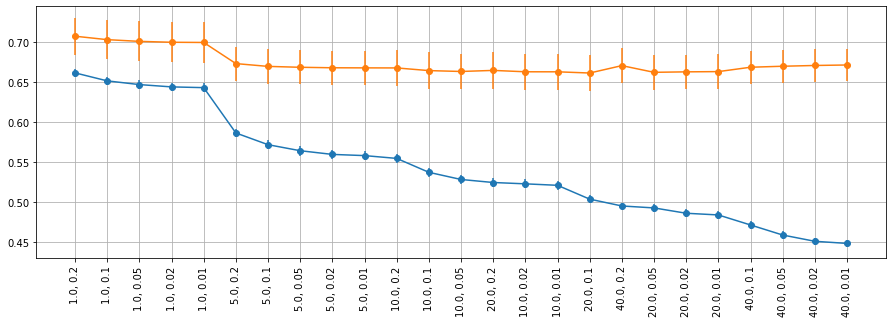

 C  epsilon  time  mae_cap_val
 1     0.20    13     0.707256
 1     0.10    16     0.702955
 1     0.05    17     0.700823
 1     0.02    18     0.699694
 1     0.01    20     0.699441
 5     0.20    14     0.673060
 5     0.10    19     0.669567
 5     0.05    23     0.668459
 5     0.02    22     0.667851
 5     0.01    24     0.667722
10     0.20    17     0.667645
10     0.10    24     0.664319
10     0.05    24     0.663226
20     0.20    22     0.664562
10     0.02    28     0.662839
10     0.01    30     0.662800
20     0.10    28     0.661292
40     0.20    37     0.670527
20     0.05    33     0.662166
20     0.02    38     0.662754
20     0.01    43     0.663055
40     0.10    44     0.668516
40     0.05    55     0.669756
40     0.02    59     0.670714
40     0.01    73     0.671327


In [18]:
run_randomized_search(
    SVR, X_train_prep, y_train, 
    param_distributions={
        'C': [1, 5, 10, 20, 40],
        'epsilon': [0.01, 0.02, 0.05, 0.1, 0.2]
    }, 
    save_memo_to='memo_svr_1.csv',
    plot_only=True
)

In [19]:
model_svr = SVR(C=5, epsilon=0.2)
crossval_scores(model_svr, X_train_prep, y_train, show_table=False)

#### Random forest regression

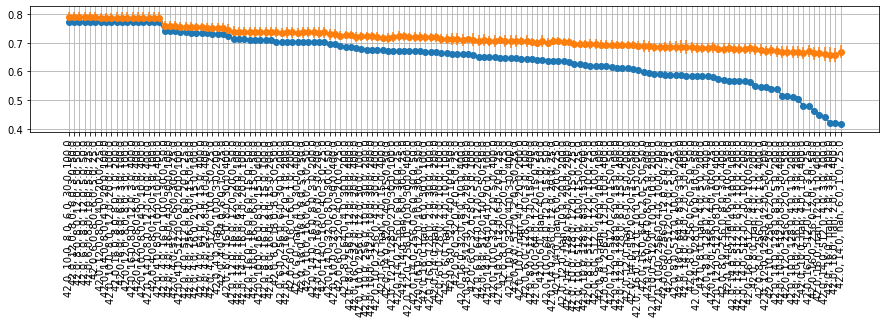

 random_state  max_depth  max_leaf_nodes  min_samples_split  min_samples_leaf  n_estimators  time  mae_cap_val
           42         10             8.0                  6                30           100     6     0.787940
           42         12             8.0                  6                 3            50     3     0.788232
           42          8             8.0                 12                 5            50     3     0.787957
           42          6             8.0                 12                 5            50     3     0.787957
           42          6             8.0                 10                 5            25     1     0.787301
           42          6             8.0                  6                 5            25     1     0.787301
           42         12             8.0                  4                20            25     1     0.786546
           42         14             8.0                  4                20           100     6     0.786482
 

In [20]:
run_randomized_search(
    RandomForestRegressor, X_train_prep, y_train, 
    param_distributions={
        'random_state': [42], 
        'max_depth': [4, 6, 8, 10, 12, 14, 16],
        'max_leaf_nodes': [8, 16, 32, 64, 128, 256, 512, None], 
        'min_samples_split': [2, 4, 6, 8, 10, 12],
        'min_samples_leaf': [1, 3, 5, 10, 15, 20, 30],
        'n_estimators': [25, 50, 100, 200, 400],
    }, 
    save_memo_to='memo_rfr_1.csv', 
    timeout=600,
    plot_only=True
)

In [21]:
model_rfr = RandomForestRegressor(random_state=42, max_depth=14, max_leaf_nodes=512, min_samples_split=2, 
                                  min_samples_leaf=10, n_estimators=200)
crossval_scores(model_rfr, X_train_prep, y_train, show_table=False)

#### Gradient boosted trees regression

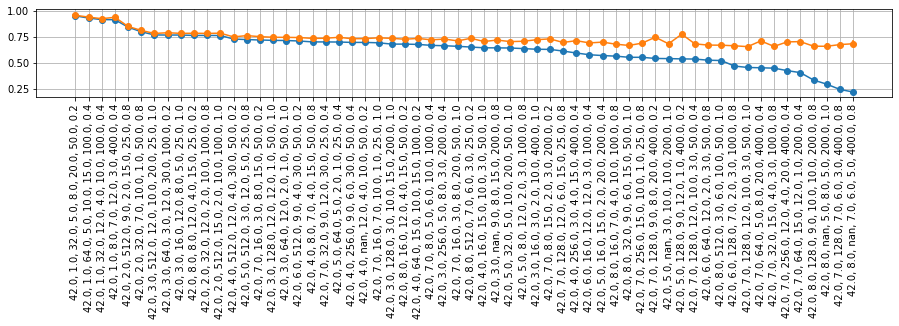

 random_state  max_depth  max_leaf_nodes  max_features  min_samples_split  min_samples_leaf  n_estimators  subsample  time  mae_cap_val
           42          1            32.0             5                  8                20            50        0.2     0     0.959811
           42          1            64.0             5                 10                15           100        0.4     0     0.942098
           42          1            32.0            12                  4                10           100        0.4     0     0.926938
           42          1             8.0             7                 12                 3           400        0.4     2     0.940245
           42          2           512.0             9                  2                15            25        0.8     0     0.851935
           42          2            32.0             7                 10                 1            50        0.8     0     0.813130
           42          3           512.0        

In [22]:
run_randomized_search(
    GradientBoostingRegressor, X_train_prep, y_train, 
    param_distributions={
        'random_state': [42],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],  # 8
        'max_leaf_nodes': [8, 16, 32, 64, 128, 256, 512, None],  # 32
        'max_features': [3, 5, 7, 9, 12, 15],  # 9
        'min_samples_split': [2, 4, 6, 8, 10, 12],  # 6
        'min_samples_leaf': [1, 3, 5, 10, 15, 20, 30],  # 15
        'n_estimators': [25, 50, 100, 200, 400],  # 50
        'subsample': [0.2, 0.4, 0.8, 1.0]  # 1.0
    }, 
    save_memo_to='memo_gbr_1.csv', 
    timeout=600,
    plot_only=True
)

In [23]:
model_gbr = GradientBoostingRegressor(max_depth=8, max_leaf_nodes=32, max_features=9, min_samples_split=6, 
                                      min_samples_leaf=15, n_estimators=50, random_state=42)
crossval_scores(model_gbr, X_train_prep, y_train, show_table=False)

#### Voting regressor

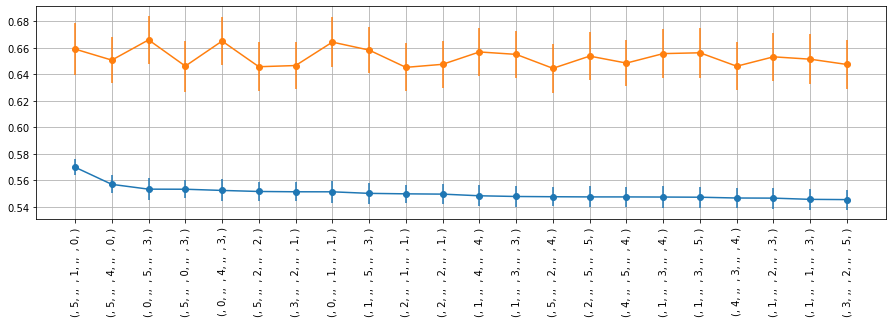

                                                                                                                                                                                                                                                                                                                                                                                             estimators   weights  time  mae_cap_val
[('svr', SVR(C=5, epsilon=0.2)), ('rfr', RandomForestRegressor(max_depth=14, max_leaf_nodes=512, min_samples_leaf=10,\n                      n_estimators=200, random_state=42)), ('gbr', GradientBoostingRegressor(max_depth=8, max_features=9, max_leaf_nodes=32,\n                          min_samples_leaf=15, min_samples_split=6,\n                          n_estimators=50, random_state=42))] (5, 1, 0)    49     0.659067
[('svr', SVR(C=5, epsilon=0.2)), ('rfr', RandomForestRegressor(max_depth=14, max_leaf_nodes=512, min_samples_leaf=10,\n                      n_estimators=200,

In [24]:
weights_pool = list(itertools.product([0, 1, 2, 3, 4, 5], repeat=3))
for i in reversed(range(len(weights_pool))):
    if weights_pool[i].count(0) > 2:
        weights_pool.pop(i)
    if gcd(*weights_pool[i]) > 1:
        weights_pool.pop(i)

run_randomized_search(
    VotingRegressor, X_train_prep, y_train, 
    param_distributions={
        'estimators': [[
            ('svr', model_svr), 
            ('rfr', model_rfr), 
            ('gbr', model_gbr), 
        ]],
        'weights': weights_pool
    }, 
    save_memo_to='memo_vr_1.csv', 
    timeout=600,
    plot_only=True
)

In [25]:
model_final = VotingRegressor(
    [
        ('svr', model_svr), 
        ('rfr', model_rfr), 
        ('gbr', model_gbr)
    ], 
    weights=[5, 2, 4]
)
crossval_scores(model_final, X_train_prep, y_train)

,MAE_train,s(MAE_train),MAE,s(MAE),RMSE_train,s(RMSE_train),RMSE,s(RMSE)
MedianEstimator,1.328628,0.007767,1.328695,0.031090,2.442109,0.017475,2.441224,0.069571
LinearRegression,0.986714,0.010949,0.992121,0.021477,1.738547,0.016755,1.745695,0.067314
SVR,0.587347,0.005673,0.673028,0.021240,1.392048,0.016013,1.477387,0.082391
RandomForestRegressor,0.565487,0.008527,0.679016,0.016785,1.149246,0.021778,1.357205,0.077048
GradientBoostingRegressor,0.552975,0.008525,0.668081,0.019607,1.049686,0.024813,1.318073,0.082357
VotingRegressor,0.548156,0.007184,0.645631,0.018083,1.175684,0.020887,1.349486,0.083391


***
## Results on the *Test Set*

In [26]:
assert list(X_train_prep.index) == list(y_train.index)
assert list(X_test_prep.index) == list(y_test.index)
assert set(X_train_prep.index).intersection(set(X_test_prep.index)) == set()

In [27]:
models = model_naive, model_lin, model_final
y_test_pred_list = []
for model in models:
    model.fit(X_train_prep, y_train)
    y_test_pred_list.append(model.predict(X_test_prep))
model_names = 'MedianEstimator', 'LinearRegression', 'VotingRegressor'

# seed the results table with the validation accuracy scores:
results_table = crossval_scores_table.copy().loc[model_names, ['MAE', 'RMSE']]
results_table.columns = [f'{col}_val' for col in results_table.columns]

# add the test set scores:
for y_test_pred_single, model_name in zip(y_test_pred_list, model_names):
    for error_func, error_func_name in zip([mae_cap, rmse_cap], ['MAE', 'RMSE']):
        results_table.at[model_name, f'{error_func_name}_test'] = error_func(y_test, y_test_pred_single)

results_table

,MAE_val,RMSE_val,MAE_test,RMSE_test
MedianEstimator,1.328695,2.441224,1.278348,2.363083
LinearRegression,0.992121,1.745695,0.954879,1.672266
VotingRegressor,0.645631,1.349486,0.592221,1.200022


Now, this is surprising! The test error appears to be lower than the validation error. This might be just a randomly different distribution of outliers in trainin and test sets. Let's see how the validation scores on different folds look like for the `VotingRegressor`.

In [28]:
folds_errors = run_crossvalidation(model_final, X_train_prep, y_train, num_splits=5, random_seed=1)
folds_errors

,mae_cap_train,mae_cap_val,rmse_cap_train,rmse_cap_val
0,0.531219,0.712498,1.140075,1.517952
1,0.556196,0.621295,1.195799,1.309058
2,0.545263,0.670656,1.174806,1.390230
3,0.560283,0.585759,1.203279,1.173854
4,0.547309,0.643665,1.162421,1.360828


#### Final predicted test set targets:

In [29]:
model_final.fit(X_train_prep, y_train)  # retrain the model

y_test_pred = pd.Series(utils.cap_y(model_final.predict(X_test_prep)), index=y_test.index, name='y_test_pred')
y_all_pred = pd.Series(utils.cap_y(model_final.predict(X_all_prep)), index=y_all.index, name='y_all_pred')

#### Dataset splits according to the charge combindations

In [30]:
mask_train_00 = X_train_prep['lhs_charge_00'] > 0
mask_train_p0 = X_train_prep['lhs_charge_+0'] > 0
mask_train_pn = X_train_prep['lhs_charge_+-'] > 0
mask_train_n0 = ~(mask_train_00 | mask_train_p0 | mask_train_pn)  # negative-neutral
mask_train_i0 = mask_train_p0 | mask_train_n0  # ion-neutral
mask_train_all = pd.Series([True] * len(X_train_prep), index=X_train_prep.index)

mask_test_00 = X_test_prep['lhs_charge_00'] > 0
mask_test_p0 = X_test_prep['lhs_charge_+0'] > 0
mask_test_pn = X_test_prep['lhs_charge_+-'] > 0
mask_test_n0 = ~(mask_test_00 | mask_test_p0 | mask_test_pn)
mask_test_i0 = mask_test_p0 | mask_test_n0
mask_test_all = pd.Series([True] * len(X_test_prep), index=X_test_prep.index)

#### The distribution of the individual test errors

,MAE_test,RMSE_test
all,0.592221,1.200022
neutral-neutral,1.288907,1.899969
ion-neutral,0.509475,1.082975
cation-anion,0.143035,0.288380


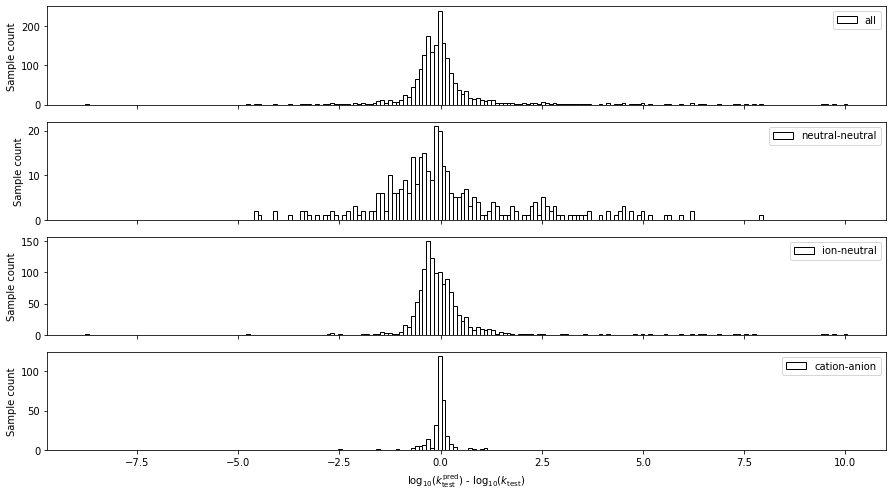

In [31]:
diff_test = y_test_pred - y_test

fig, axes = plt.subplots(4, 1, figsize=(fw, fh), sharex='all')
min_val, max_val = min(diff_test), max(diff_test)
bins = np.linspace(min_val, max_val, 200)

masks = [mask_test_all, mask_test_00, mask_test_i0, mask_test_pn]
labels = ['all', 'neutral-neutral', 'ion-neutral', 'cation-anion']
partial_test_errors = pd.DataFrame()

for ax, mask, lab in zip(axes, masks, labels):
    partial_test_errors.at[lab, 'MAE_test'] = mae_cap(y_test[mask.values], y_test_pred[mask.values])
    partial_test_errors.at[lab, 'RMSE_test'] = rmse_cap(y_test[mask.values], y_test_pred[mask.values])
    
    ax.hist(diff_test.loc[mask], bins=bins, color='white', edgecolor='black', label=lab)
    ax.set_ylabel('Sample count')
    if ax is axes[-1]:
        ax.set_xlabel('log$_{10}$($k_\mathrm{test}^\mathrm{pred}$) - log$_{10}$($k_\mathrm{test}$)')
    ax.legend()
fig.tight_layout()

partial_test_errors


#### Train each dataset split separately
Three models trained separately for different reactants charges combinations. Using the `VotingRegressor` optimized for the full model though. Will it yield better performance?

In [32]:
partial_test_errors_dedicated = partial_test_errors.copy()

test_masks = [mask_test_all, mask_test_00, mask_test_i0, mask_test_pn]
train_masks = [mask_train_all, mask_train_00, mask_train_i0, mask_train_pn]

for mask_train, mask_test, lab in zip(train_masks, test_masks, labels):
    X_train_part, y_train_part = X_train.loc[mask_train], y_train.loc[mask_train]
    X_test_part, y_test_part = X_test.loc[mask_test], y_test.loc[mask_test]
    X_train_part_prep = transform_scale_pipeline.fit_transform(X_train_part.copy())
    X_test_part_prep = transform_scale_pipeline.transform(X_test_part.copy())
    # train the model:
    model_final.fit(X_train_part_prep, y_train_part)
    y_test_part_pred = model.predict(X_test_part_prep)
    for error_func, error_func_name in zip([mae_cap, rmse_cap], ['MAE', 'RMSE']):
        partial_test_errors_dedicated.at[lab, f'{error_func_name}_test (dedicated model)'] = error_func(y_test_part, y_test_part_pred)
        
partial_test_errors_dedicated

,MAE_test,RMSE_test,MAE_test (dedicated model),RMSE_test (dedicated model)
all,0.592221,1.200022,0.592221,1.200022
neutral-neutral,1.288907,1.899969,1.310785,1.938249
ion-neutral,0.509475,1.082975,0.504393,1.062508
cation-anion,0.143035,0.288380,0.142195,0.253683


#### Recovery of the distribution shape of the target values (on the test set only)

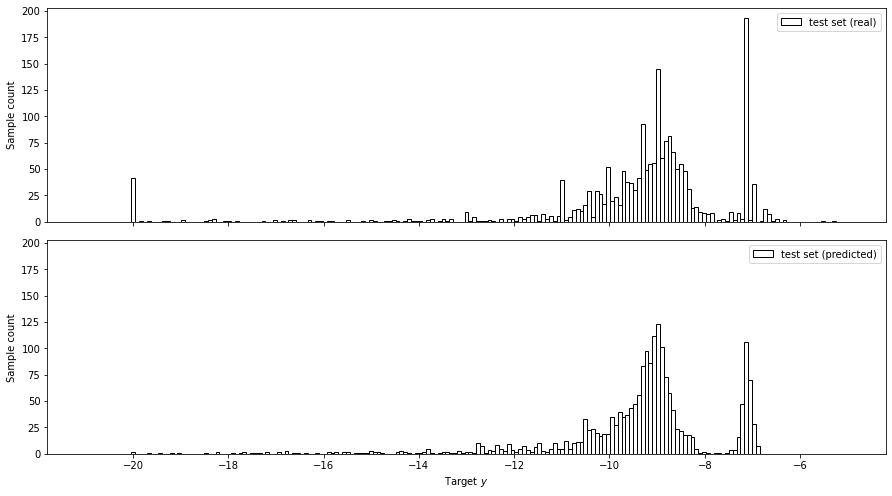

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(fw, fh), sharex='all', sharey='all')
bins = np.linspace(-21, -5, 200)
ax1, ax2 = axes
ax1.hist(y_test, bins=bins, color='white', edgecolor='black', label='test set (real)')
ax2.hist(y_test_pred, bins=bins, color='white', edgecolor='black', label='test set (predicted)')
for ax in (ax1, ax2):
    ax.set_ylabel('Sample count')
    ax.legend()
ax2.set_xlabel('Target $y$')

fig.tight_layout();

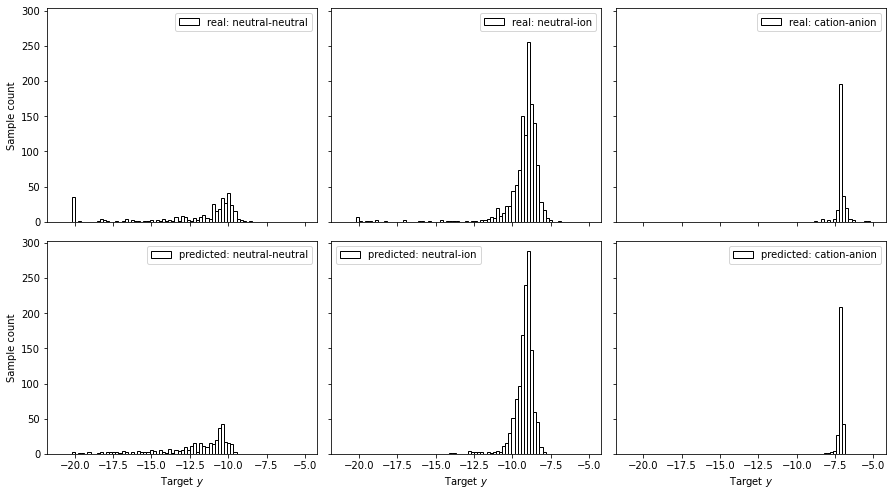

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(fw, fh), sharex='all', sharey='all')
bins = np.linspace(-21, -5, 80)
for row, row_lab, y_series in zip(axes, ['real', 'predicted'], [y_test, y_test_pred]):
    for ax, col_lab, mask in zip(row, ['neutral-neutral', 'neutral-ion', 'cation-anion'], [mask_test_00, mask_test_i0, mask_test_pn]):
        ax.hist(y_series.loc[mask], bins=bins, color='white', edgecolor='black', label=f'{row_lab}: {col_lab}')
        ax.legend()
        if row_lab == 'predicted':
            ax.set_xlabel('Target $y$')
        if ax is row[0]:
            ax.set_ylabel('Sample count')
fig.tight_layout();

#### Features importance

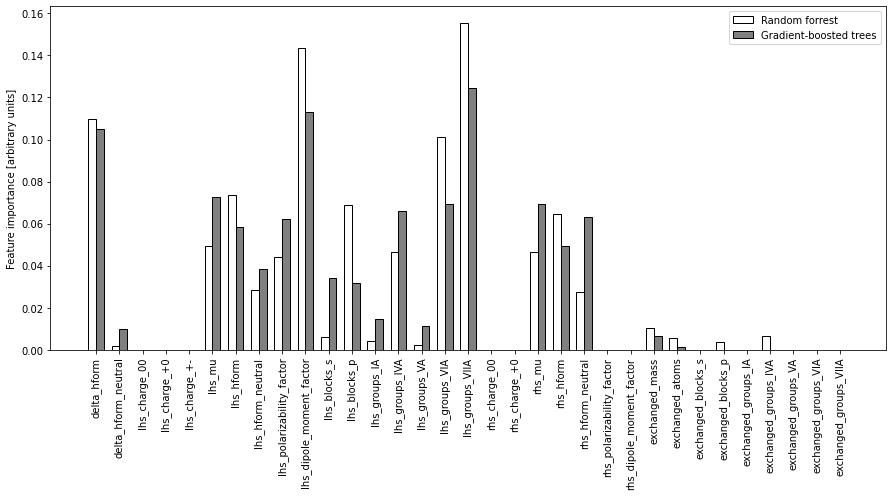

In [35]:
features = [
    'delta_hform', 'delta_hform_neutral',
    'lhs_charge_00', 'lhs_charge_+0', 'lhs_charge_+-', 
    'lhs_mu', 'lhs_hform', 'lhs_hform_neutral',
    'lhs_polarizability_factor', 'lhs_dipole_moment_factor', 
    'lhs_blocks_s', 'lhs_blocks_p', 
    'lhs_groups_IA', 'lhs_groups_IVA', 'lhs_groups_VA', 'lhs_groups_VIA', 'lhs_groups_VIIA',
    'rhs_charge_00', 'rhs_charge_+0', 
    'rhs_mu', 'rhs_hform', 'rhs_hform_neutral',
    'rhs_polarizability_factor', 'rhs_dipole_moment_factor', 
    'exchanged_mass', 'exchanged_atoms', 
    'exchanged_blocks_s', 'exchanged_blocks_p',
    'exchanged_groups_IA', 'exchanged_groups_IVA', 'exchanged_groups_VA', 'exchanged_groups_VIA', 'exchanged_groups_VIIA'
]

fig, ax = plt.subplots(1, 1, figsize=(fw, fh))

feature_importance_frame = pd.DataFrame()

for model_name, model_lab, offset, color in zip(['rfr', 'gbr'], ['Random forrest', 'Gradient-boosted trees'], [0, 1], ['white', 'gray']):
    feature_importances = pd.Series(
        model_final.named_estimators_[model_name].feature_importances_,
        index=X_train_prep.columns
    )
    assert len(features) == len(feature_importances)
    assert set(features) == set(feature_importances.index)
    feature_importance_frame[model_lab] = feature_importances
    
    pos = np.arange(len(features)) * 3 + offset
    vals = feature_importances.loc[features].values
    ax.bar(pos, vals, color=color, edgecolor='black', label=model_lab, width=1.)

ax.legend()
ax.set_xticks(np.arange(len(features)) * 3 + 0.5)
ax.set_xticklabels(features, rotation=90)
ax.set_ylabel('Feature importance [arbitrary units]')
# ax.set_yscale('log')
    
fig.tight_layout()

#### Analysis of the biggest outliers

In [36]:
reaction_fingerprints = pd.Series(dtype=object)
for r_id in ds_raw.index:
    r_str = ds_raw.at[r_id, 'reaction_string']
    reactants_str, products_str = r_str.split(' -> ')
    reactants, products = reactants_str.split(' + '), products_str.split(' + ')
    reaction_fingerprint = (str(
        (tuple(sorted(reactants)), tuple(sorted(products)))
    ))
    reaction_fingerprints.loc[r_id] = reaction_fingerprint

reaction_strings = ds_raw['reaction_string']

In [37]:
diff_all = y_all_pred - y_all
n = 10

low_estimates = diff_all.sort_values()[:n]
high_estimates = diff_all.sort_values(ascending=False)[:n]
underestimated = pd.DataFrame(index=low_estimates.index)
overestimated = pd.DataFrame(index=high_estimates.index)

for outlying, table, ascending in zip([high_estimates, low_estimates], 
                                      [overestimated, underestimated],
                                      [True, False]):
    table.loc[outlying.index, 'reaction_string'] = reaction_strings[outlying.index]
    
    for r_id in table.index:
        table.loc[r_id, 'prediction_error'] = f'{outlying.loc[r_id]:.2f}'
        table.loc[r_id, 'k_predicted'] = f'{10 ** y_all_pred.loc[r_id]:.2e}'
        for j, log_k in enumerate(y_all.loc[reaction_fingerprints == reaction_fingerprints.loc[r_id]].sort_values(ascending=ascending)):
            table.at[r_id, f'k_real_{j + 1}'] = f'{10 ** log_k:.2e}'
    table.fillna('', inplace=True)

def print_table_latex(table):
    with pd.option_context("max_colwidth", 1000):
        latex = table.to_latex(
            formatters = {
                'reaction_string': lambda x: f'${Reaction(x).latex}$'
            },
            escape=False,
        )
    print(latex)
        


In [38]:
overestimated

,reaction_string,prediction_error,k_predicted,k_real_1,k_real_2,k_real_3
7800,C4H3+ + HCN -> C4H2 + HCNH+,10.72,5.19e-10,1.00e-20,,
213,H+ + HCN -> HCN + H+,10.57,3.72e-10,1.00e-20,1.00e-09,1.47e-08
2569,CH3 + HCO+ -> CO + CH4+,10.06,1.14e-10,1.00e-20,,
5105,HCNH+ + C3H2 -> HCN + C3H3+,9.84,6.92e-11,1.00e-20,1.96e-09,
9044,C8H2 + HCNH+ -> HCN + C8H3+,9.68,4.77e-11,1.00e-20,,
5041,N2 + NH4+ -> NH3 + N2H+,9.56,3.61e-11,1.00e-20,,
3540,H2O + HCNH+ -> HCN + H3O+,9.55,3.51e-11,1.00e-20,1.00e-20,8.80e-13
3541,H2O + HCNH+ -> HCN + H3O+,9.55,3.51e-11,1.00e-20,1.00e-20,8.80e-13
5403,HCO+ + N2 -> CO + N2H+,9.50,3.13e-11,1.00e-20,6.70e-10,2.00e-09
8560,C6H2 + HCNH+ -> HCN + C6H3+,9.45,2.79e-11,1.00e-20,,


In [39]:
underestimated

,reaction_string,prediction_error,k_predicted,k_real_1,k_real_2,k_real_3
7041,CH3CHCH2 + H3+ -> H2 + C3H7+,-17.89,9.36e-09,7.26e+09,,
3837,H3O+ + C3H2 -> H2O + C3H3+,-8.78,1.66e-09,1.00e+00,4.60e-09,3.00e-09
7495,C4H + S+ -> CS + C3H+,-8.59,1.28e-09,4.98e-01,,
7494,C4H + S+ -> H + C4S+,-8.24,2.85e-09,4.98e-01,3.17e-09,1.00e-09
5114,C2H4 + H -> C2H3 + H2,-7.28,4.70e-17,9.00e-10,1.00e-20,
97,H + OCN -> CN + OH,-6.69,2.04e-17,1.00e-10,,
4427,C2H2 + H -> C2H + H2,-6.39,4.11e-17,1.00e-10,1.00e-20,1.00e-20
949,C + H2 -> CH + H,-5.87,2.00e-16,1.50e-10,1.00e-20,
2690,O + H2 -> OH + H,-5.87,4.63e-16,3.44e-10,9.16e-18,1.00e-20
7848,CH2F2 + H -> CHF2 + H2,-5.56,4.11e-16,1.49e-10,,


#### Correlation between prediction errors and missing data
Trying to detect some correlation between the number of missing species attributes, which look important (such as hform on both sides, or polarizability and dipole moment among the reactants), and the prediction error.

In [40]:
missing_features = pd.DataFrame(index=ds_raw.index)
for attr in ['hform', 'polarizability', 'dipole_moment']:
    for side, rp in zip(['lhs', 'rhs'], ['reactant', 'product']):
        missing_features.loc[:, f'{side}_{attr}'] = ds_raw.loc[:, [f'{rp}_1_{attr}', f'{rp}_2_{attr}']].isna().sum(axis='columns')
missing_features['hform'] = missing_features.loc[:, ['lhs_hform', 'rhs_hform']].sum(axis='columns')
missing_features.drop(columns=['lhs_hform', 'rhs_hform', 'rhs_polarizability', 'rhs_dipole_moment'], inplace=True)
missing_features

,lhs_polarizability,lhs_dipole_moment,hform
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,1,0
...,...,...,...
9465,2,2,4
9466,2,2,4
9467,1,1,1
9468,1,1,1


,samples,MAE
0,5515.0,0.643075
1,3284.0,0.467460
2,671.0,0.316459


,samples,MAE
0,5925.0,0.625112
1,2965.0,0.472811
2,580.0,0.324771


,samples,MAE
0,5067.0,0.681422
1,2592.0,0.441947
2,1650.0,0.410222
3,127.0,0.102617
4,34.0,0.171994


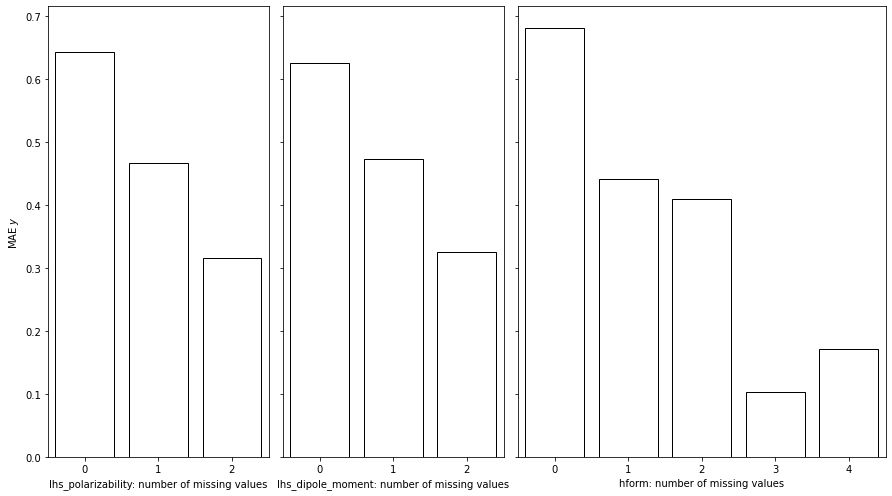

In [41]:
fig, axes = plt.subplots(1, len(missing_features.columns), sharey='row', figsize=(fw, fh), 
                         gridspec_kw={'width_ratios': [3, 3, 5]})

for i, col in enumerate(missing_features.columns):
    ax = axes[i]
    missing_features_errors = pd.DataFrame()
    for missing in sorted(set(missing_features[col])):
        mask = missing_features[col] == missing
        y_subset = y_all[mask]
        y_subset_pred = y_all_pred[mask]
        missing_features_errors.at[missing, 'samples'] = len(y_subset)
        missing_features_errors.at[missing, 'MAE'] = mae_cap(y=y_subset, y_pred=y_subset_pred)
    
    display(missing_features_errors)
    
    ax.set_xlabel(f'{col}: number of missing values')
    if ax is axes[0]:
        ax.set_ylabel('MAE $y$')
    ax.bar(missing_features_errors.index, missing_features_errors['MAE'], color='white', edgecolor='black')
    ax.set_xticks(missing_features_errors.index)
    ax.set_xlim(-0.5, missing_features_errors.index[-1] + 0.5)
    
    fig.tight_layout();

The errors appear to be much lower on samples where the species properties were imputed. The errors also correlate with the sample size, but that should be ierrelevant. The correlation is caused by the data bias: more missing values shifts the ratio of ion-neutral and ion-ion reactions higher, and those get predicted with lower error.

***
## Save the trained model persistently

Combine the transformation and scaling pipeline with the final model to a single pipeline (adding also capping of the predicted values and transforming them back from logarithmic space to the true rate coefficients). 
Then, retrain the model on the full dataset and store the model persistently using the `joblib` library.

In [42]:
# chain the data transformation pipeline and the final regression model:
final_regression_pipeline_persistent = make_pipeline(
    transform_scale_pipeline,
    utils.FinalModelWrapper(model_final)
)

# train it on the *full* dataset:
final_regression_pipeline_persistent.fit(X, y)

# store the trained model:
joblib.dump(final_regression_pipeline_persistent, utils.final_regression_pipeline_name);

Training MAE: 0.5412103463026942


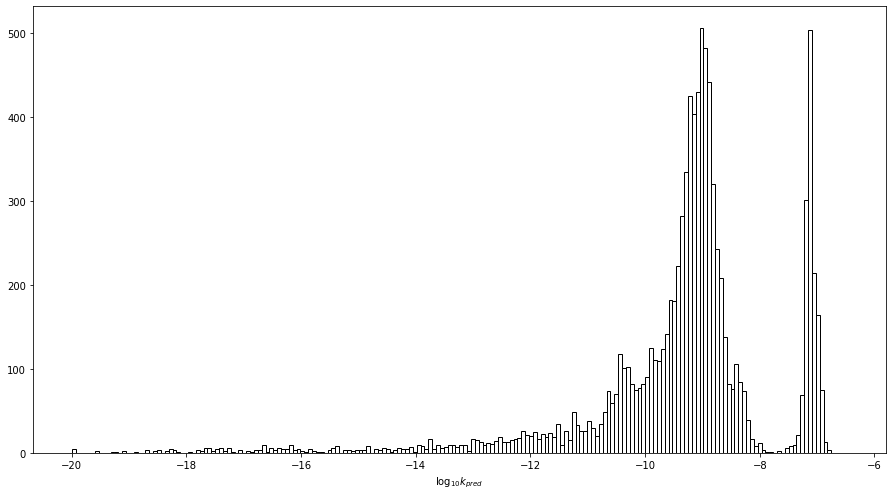

In [43]:
# load the trained regression pipeline from disk and predict:
y_pred_persistent = pd.Series(utils.get_final_regression_pipeline().predict(X), index=X.index)

fig, ax = plt.subplots(figsize=(fw, fh))
ax.hist(np.log10(y_pred_persistent), bins=200, color='white', edgecolor='black', label='test set (real)')
ax.set_xlabel(r'$\log_{10} k_{pred}$')
fig.tight_layout()

print(f'Training MAE: {(np.log10(y_pred_persistent) - y).abs().mean()}')

In [44]:
sample_input = pd.read_csv('sample_input.csv', header=0, index_col=0)
sample_input

,reactant_1_name,reactant_1_mass,reactant_1_charge,reactant_1_hform,reactant_1_hform_neutral,reactant_1_polarizability,reactant_1_dipole_moment,reactant_2_name,reactant_2_mass,reactant_2_charge,...,product_2_groups_IA,product_2_groups_IVA,product_2_groups_VA,product_2_groups_VIA,product_2_groups_VIIA,exchanged_groups_IA,exchanged_groups_IVA,exchanged_groups_VA,exchanged_groups_VIA,exchanged_groups_VIIA
1824,CH,13.019,0,595.800,595.800,2.120,1.394,N+,14.007000,1,...,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0
409,H+,1.008,1,1536.244,217.998,NaN,0.000,CH3NCO,57.052000,0,...,3,2,1,1,0,0.0,0.0,0.0,0.0,0.0
4506,C2H2,26.038,0,228.200,228.200,3.487,0.000,C4H,49.052000,0,...,2,6,0,0,0,0.0,4.0,0.0,0.0,0.0
4012,C2+,24.022,1,1980.050,826.799,4.597,0.000,D2,4.028204,0,...,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3657,H2O+,18.015,1,981.806,-241.826,0.649,-2.280,CH3Br,94.939000,0,...,2,0,0,1,0,0.0,0.0,0.0,0.0,0.0
2286,CH2,14.027,0,391.200,391.200,1.552,-0.712,CH3+,15.035000,1,...,2,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1679,C+,12.011,1,1809.444,716.670,0.776,0.000,C6H-,73.074000,-1,...,1,6,0,0,0,0.0,0.0,0.0,0.0,0.0
8935,C8,96.088,0,1458.866,1458.866,23.959,0.000,H3+,3.024000,1,...,1,8,0,0,0,1.0,0.0,0.0,0.0,0.0
1424,C+,12.011,1,1809.444,716.670,0.776,0.000,CH2CCH,39.057000,0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0
6912,Ar+,39.950,1,1520.580,0.000,NaN,NaN,N2O,44.013000,0,...,0,0,2,1,0,0.0,0.0,0.0,0.0,0.0


In [45]:
utils.get_final_regression_pipeline().predict(sample_input)

array([1.18797400e-09, 5.29729997e-09, 9.87500861e-11, 3.15630581e-10,
       1.89232973e-09, 8.37593678e-10, 6.48672484e-08, 1.77991274e-09,
       9.38216266e-10, 1.66151833e-10])

In [46]:
from sklearn import set_config
set_config(display='diagram')

final_regression_pipeline_persistent

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('imputer', SpeciesAttributesImputer()),
                                 ('transformer',
                                  SpeciesAttributesTransformer()),
                                 ('scaler', Scaler())])),
                ('finalmodelwrapper',
                 FinalModelWrapper(model=VotingRegressor(estimators=[('svr',
                                                                      SVR(C=5,
                                                                          epsilon=0.2)),
                                                                     ('rfr',
                                                                      RandomForestRegressor(max_depth=14,
                                                                                            max_leaf_nodes=512,
                                                                                            min_samples_leaf=10,
                                                                                            n_estimators=200,
                                                                                            random_state=42)),
                                                                     ('gbr',
                                                                      GradientBoostingRegressor(max_depth=8,
                                                                                                max_features=9,
                                                                                                max_leaf_nodes=32,
                                                                                                min_samples_leaf=15,
                                                                                                min_samples_split=6,
                                                                                                n_estimators=50,
                                                                                                random_state=42))],
                                                         weights=[5, 2, 4])))])